### Итоговая аттестация.

В качестве итогового проекта я выбрала датасет №18, который содержит информацию о внешности людей. В качестве задания необходимо построить модель, которая будет предсказывать какого пола человек, основываясь на его внешности. 

**1. Загрузка и предобработка данных.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import pearsonr
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score, accuracy_score

In [2]:
df = pd.read_csv('gender_classification_v7.csv')
df.shape

(5001, 8)

**2. Описательный анализ данных.**

In [3]:
df.sample(10)

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
881,1,15.4,7.1,1,1,1,1,Male
375,1,13.2,6.0,0,0,0,0,Female
451,1,12.5,5.3,1,1,1,0,Male
2240,1,13.2,5.4,0,0,1,0,Female
3655,1,14.2,5.3,1,1,1,1,Male
3393,1,12.8,6.1,0,0,0,0,Female
4530,1,13.5,7.1,1,1,1,1,Male
453,1,12.8,6.2,0,0,0,0,Female
4228,1,13.8,6.0,0,0,0,0,Female
3812,1,13.0,5.9,0,1,0,0,Female


* `long_hair` - столбец содержит значения *0* и *1*, где *1* - длинные волосы, *0* - короткие;
* `forehead_width_cm` - столбец содержит информацию о ширине лба (в сантиметрах);
* `forehead_height_cm` - столбец содержит информацию о высоте лба (в сантиметрах);
* `nose_wide` - столбец содержит значения *0* и *1*, где *1* - широкий нос, *0* - узкий;
* `nose_long` - столбец содержит значения *0* и *1*, где *1* - длинный нос, *0* - короткий;
* `lips_thin` - столбец содержит значения *0* и *1*, где *1* - тонкие губы, *0* - пухлые;
* `distance_nose_to_lip_long` - столбец содержит значения *0* и *1*, где *1* - большое расстояние между носом и губами, *0* - маленькое расстояние между носом и губами;
* `gender` - целевой признак, содержит значения 'Male' и 'Female'.

Итак, у нас есть *8* столбцов и *5001* строка.

*7* колонок с числовыми значениями: `long_hair`, `forehead_width_cm`, `forehead_height_cm`, `nose_wide`, `nose_long`, `lips_thin`, `distance_nose_to_lip_long`.

*1* колонка с категориальными значениями: `gender`.

In [4]:
df.isnull().sum()

long_hair                    0
forehead_width_cm            0
forehead_height_cm           0
nose_wide                    0
nose_long                    0
lips_thin                    0
distance_nose_to_lip_long    0
gender                       0
dtype: int64

Пропуски в данных отсутствуют.

**3. Построение графиков.**

In [5]:
gender_counts = df['gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']

fig = px.pie(gender_counts, names='Gender', values='Count',
             color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_layout(
    title={
        'text': 'Count of Male and Female',
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}
    }
)

fig.show()

In [6]:
df['gender'].value_counts()

gender
Female    2501
Male      2500
Name: count, dtype: int64

Видим, что в датасете представлены данные *2501* женщины и *2500* мужчин.

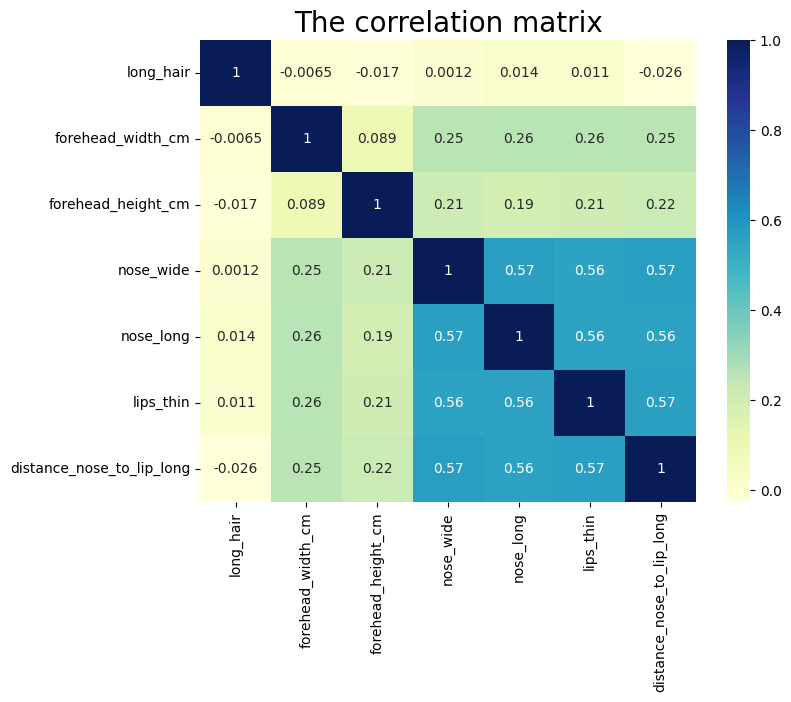

In [7]:
df_numeric = df.drop(columns='gender', axis=1)
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('The correlation matrix', fontsize=20)
plt.show()

Из построенной матрицы корреляции видно, что заметно между собой коррелируют признаки: толщина носа (`nose_wide`), длина носа (`nose_long`), толщина губ (`lips_thin`) и расстояние между носом и губами (`distance_nose_to_lip_long`).

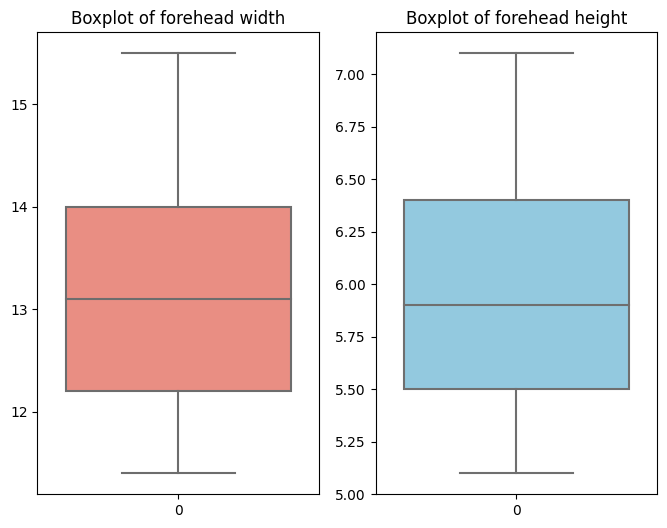

In [8]:
plt.figure(figsize=(8, 6))

# Построение ящика с усами для столбца forehead_width_cm
plt.subplot(121)
sns.boxplot(data=df['forehead_width_cm'], color='salmon')
plt.title('Boxplot of forehead width')

# Построение ящика с усами для столбца forehead_height_cm
plt.subplot(122)
sns.boxplot(data=df['forehead_height_cm'], color='skyblue')
plt.title('Boxplot of forehead height')

plt.show()

Из построенных графиков видно, что показатели ширины и высоты лба находятся в пределах норм и никаких выбросов не наблюдается.

Для измерений ширины лба (`forehead_width_cm`) среднее значение чуть больше *13* сантиметров, норма от *12,3* до *14* сантиметров.

Для измерений высоты лба (`forehead_height_cm`) среднее значение около *6* сантиметров, норма от *5,5* до *6,4* сантиметров.

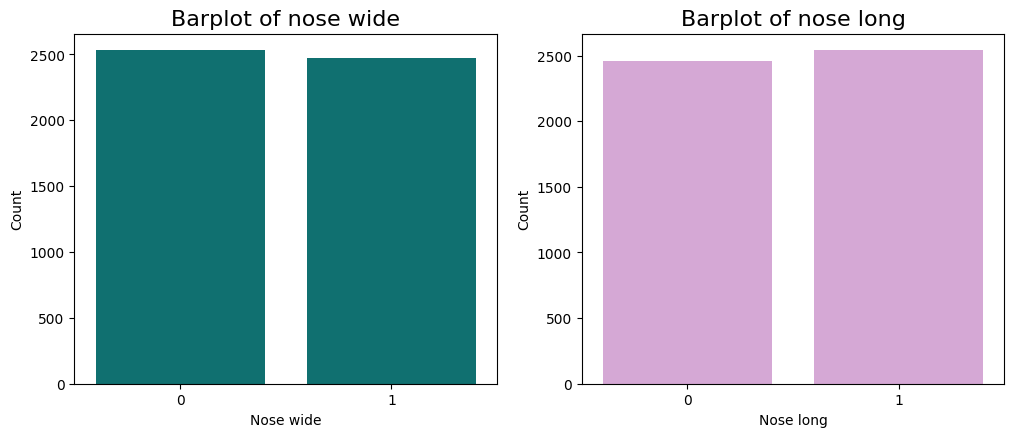

In [9]:
plt.figure(figsize=(12,10))

# Построение столбчатой диаграммы для столбца nose_wide
plt.subplot(221)
plt.title("Barplot of nose wide", fontsize=16)
sns.countplot(x="nose_wide", data=df, color='teal')
plt.xlabel('Nose wide')
plt.ylabel("Count")

# Построение столбчатой диаграммы для столбца nose_long
plt.subplot(222)
plt.title("Barplot of nose long", fontsize=16)
sns.countplot(x="nose_long", data=df, color='plum')
plt.xlabel('Nose long')
plt.ylabel("Count")

plt.show()

Из построенных графиков видно, что в данных примерно поровну распределены показатели ширины (`nose_wide`) и длины (`nose_long`) носа.

Больше данных о людях с узкими и длинными носами. 

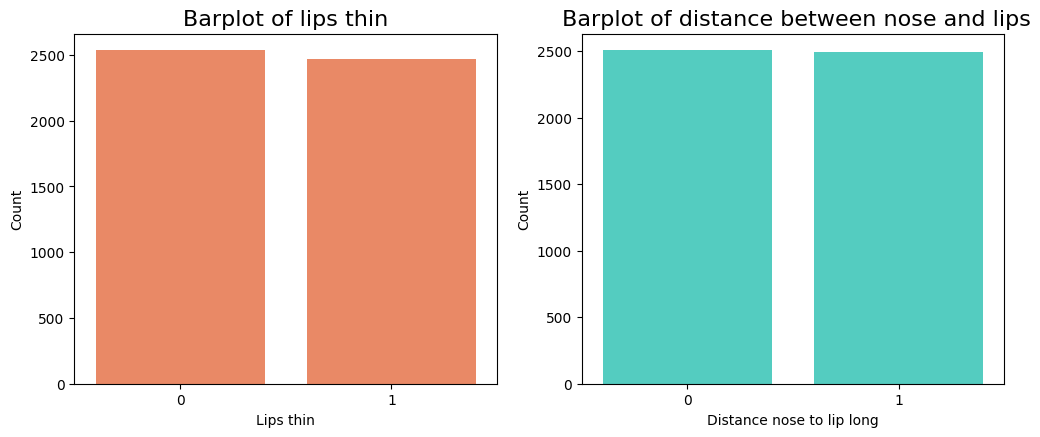

In [10]:
plt.figure(figsize=(12,10))

# Построение столбчатой диаграммы для столбца lips_thin
plt.subplot(221)
plt.title("Barplot of lips thin", fontsize=16)
sns.countplot(x="lips_thin", data=df, color='coral')
plt.xlabel('Lips thin')
plt.ylabel("Count")

# Построение столбчатой диаграммы для столбца distance_nose_to_lip_long
plt.subplot(222)
plt.title(" Barplot of distance between nose and lips", fontsize=16)
sns.countplot(x="distance_nose_to_lip_long", data=df, color='turquoise')
plt.xlabel('Distance nose to lip long')
plt.ylabel("Count")

plt.show()

Из построенных графиков видно, что примерно поровну распределены данные в столбцах с информацией о толщине губ (`lips_thin`) и расстоянии между носом и губами (`distance_nose_to_lip_long`).

Немного больше данных о людях с тонкими губами и с маленьким расстоянием между носом и губами.

**4. Проверка гипотез.**

Сформулируем двустороннюю альтернативную гипотезу: 

* H0 - длина носа человека не влияет на расстояние между носом и губами;

* H1 - длина носа человека влияет на расстояние между носом и губами.

In [11]:
correlation, p_value = pearsonr(df['nose_long'], df['distance_nose_to_lip_long'])

alpha = .05

if p_value < alpha:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза отвергается. Длина носа влияет на расстояние между носом и губами.')
else:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза подтверждается. Длина носа не влияет на расстояние между носом и губами.')


P-value: 0.00000. Нулевая гипотеза отвергается. Длина носа влияет на расстояние между носом и губами.


Сформулируем двустороннюю альтернативную гипотезу:

* H0 - толщина носа у мужчин и у женщин не различается;

* H1 - толщина носа у мужчин и у женщин различается.

In [12]:
wide_male = df[df['gender'] == 'Male']['nose_wide']
wide_female = df[df['gender'] == 'Female']['nose_wide']

alpha = .05

t_statistic, p_value = stats.ttest_ind(wide_male, wide_female, equal_var=False)

if p_value < alpha:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза отвергается. Толщина носа у мужчин и у женщин различается.')
else:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза подтверждается. Толщина носа у мужчин и у женщин не различается.')

P-value: 0.00000. Нулевая гипотеза отвергается. Толщина носа у мужчин и у женщин различается.


Сформулируем одностороннюю альтернативную гипотезу:

* H0 - высота лба у мужчин и у женщин не различается;

* H1 - у мужчин высота лба больше, чем у женщин.

In [13]:
heights_male = df[df['gender'] == 'Male']['forehead_height_cm']
heights_female = df[df['gender'] == 'Female']['forehead_height_cm']

alpha = .05

t_statistic, p_value = stats.ttest_ind(heights_male, heights_female, 
                                       equal_var=False)

if p_value < alpha:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза отвергается. У мужчин высота лба больше, чем у женщин.')
else:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза подтверждается. Высота лба у мужчин и у женщин не различается.')


P-value: 0.00000. Нулевая гипотеза отвергается. У мужчин высота лба больше, чем у женщин.


Сформулируем одностороннюю альтернативную гипотезу:

* H0 - ширина лба у мужчин и у женщин не различается;

* H1 - у мужчин лоб шире, чем у женщин.

In [14]:
width_male = df[df['gender'] == 'Male']['forehead_width_cm']
width_female = df[df['gender'] == 'Female']['forehead_width_cm']

alpha = .05

t_statistic, p_value = stats.ttest_ind(width_male, width_female, 
                                       equal_var=False)

if p_value < alpha:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза отвергается. У мужчин лоб шире, чем у женщин.')
else:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза подтверждается. Ширина лба у мужчин и у женщин не различается.')


P-value: 0.00000. Нулевая гипотеза отвергается. У мужчин лоб шире, чем у женщин.


Сформулируем одностороннюю альтернативную гипотезу:

* H0 - губы мужчин тоньше, чем губы женщин;

* H1 - губы мужчин не тоньше губ женщин.

In [15]:
lips_thin_male = df[df['gender'] == 'Male']['lips_thin']
lips_thin_female = df[df['gender'] == 'Female']['lips_thin']

alpha = .05

t_statistic, p_value = stats.ttest_ind(lips_thin_male, lips_thin_female, 
                                       equal_var=False)

if p_value < alpha:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза отвергается. Губы мужчин не тоньше губ женщин.')
else:
    print(f'P-value: {p_value:.5f}. Нулевая гипотеза подтверждается. Губы мужчин тоньше, чем губы женщин.')


P-value: 0.00000. Нулевая гипотеза отвергается. Губы мужчин не тоньше губ женщин.


**5. Промежуточный отчёт-вывод по исследованию.**

* В датасете представлены данные *2501* женщины и *2500* мужчин;
* Заметно между собой коррелируют признаки: толщина носа (`nose_wide`), длина носа (`nose_long`), толщина губ (`lips_thin`) и расстояние между носом и губами (`distance_nose_to_lip_long`);
* Для измерений ширины лба (`forehead_width_cm`) среднее значение чуть больше *13* сантиметров, норма от *12,3* до *14* сантиметров;
* Для измерений высоты лба (`forehead_height_cm`) среднее значение около *6* сантиметров, норма от *5,5* до *6,4* сантиметров;
* В данных примерно поровну распределены показатели ширины (`nose_wide`) и длины (`nose_long`) носа; больше данных о людях с узкими и длинными носами;
* Примерно поровну распределены данные в столбцах с информацией о толщине губ (`lips_thin`) и расстоянии между носом и губами (`distance_nose_to_lip_long`); немного больше данных о людях с тонкими губами и с маленьким расстоянием между носом и губами;
* Длина носа влияет на расстояние между носом и губами;
* Толщина носа у мужчин и у женщин различается;
* У мужчин высота и ширина лба больше, чем у женщин;
* Губы мужчин не тоньше губ женщин.

**6. Определение решающей задачи.**

Так как необходимо предсказать пол человека, основываясь на его внешности, то это задача классификации. Целевой признак - пол (`gender`) - категориальный и принимает ограниченный набор классов (male, female). Модели будут анализировать внешние признаки и классифицировать людей в один из двух классов.

**7. Создание логистических моделей и выбор лучшей модели.**

In [16]:
# Разделим датасет на три выборки: тренировочную, валидационную, тестовую
X = df.drop(columns='gender', axis=1)
y = df['gender']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, 
                                                random_state=42)

In [17]:
# Создадим несколько моделей
model_random_forest_classifier = RandomForestClassifier(random_state=42)
model_logistic_regression = LogisticRegression(random_state=42)
model_svc = SVC(random_state=42)
model_xgb = XGBClassifier(objective='binary:logistic', random_state=42)
model_knn = KNeighborsClassifier()

In [18]:
# Обучение моедли случайного леса
model_random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Обучение моедли логистической регрессии
model_logistic_regression.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [20]:
# Обучение модели SVC
model_svc.fit(X_train, y_train)

SVC(random_state=42)

In [21]:
# Изменим значения целевого признака на числовые для обучения модели XGBoost
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [22]:
# Обучение модели градиентного бустинга
model_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [23]:
# Обучение модели KNN
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [24]:
# Создание списка базовых моделей для стекинга
base_models = [
    ('RandomForest', model_random_forest_classifier),
    ('LogisticRegression', model_logistic_regression),
    ('SVC', model_svc),
    ('XGBoost', model_xgb),
    ('KNN', model_knn)
]

# Создание мета-модели 
meta_model = SVC(random_state=42)

stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, cv=5)

stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('RandomForest',
                                RandomForestClassifier(random_state=42)),
                               ('LogisticRegression',
                                LogisticRegression(random_state=42)),
                               ('SVC', SVC(random_state=42)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...)),
                               ('KNN', KNeighborsClassifier())],
                   final_estimator=SVC(random_state=42))

In [25]:
# Оценка качества модели случайного леса
y_val_pred_random_forest_classifier = model_random_forest_classifier.predict(X_val)
f1_val_pred_random_forest_classifier = f1_score(y_val, 
                                                y_val_pred_random_forest_classifier, 
                                                pos_label='Male')
print(f'F1-score на валидационной выборке модели случайного леса: {f1_val_pred_random_forest_classifier:.4f}')

F1-score на валидационной выборке модели случайного леса: 0.9640


In [26]:
# Оценка качества модели логистической регрессии
y_val_pred_logistic_regression = model_logistic_regression.predict(X_val)
f1_val_pred_logistic_regression = f1_score(y_val, 
                                           y_val_pred_logistic_regression, 
                                           
                                           pos_label='Male')
print(f'F1-score на валидационной выборке модели логистической регрессии: {f1_val_pred_logistic_regression:.4f}')

F1-score на валидационной выборке модели логистической регрессии: 0.9600


In [27]:
# Оценка качества модели SVC
y_val_pred_svc = model_svc.predict(X_val)
f1_val_pred_svc = f1_score(y_val, y_val_pred_svc, pos_label='Male')
print(f'F1-score на валидационной выборке модели SVC: {f1_val_pred_svc:.4f}')

F1-score на валидационной выборке модели SVC: 0.9679


In [28]:
# Оценка качества модели градиентного бустинга
y_val_pred_xgb = model_xgb.predict(X_val)
f1_val_pred_xgb = f1_score(y_val_encoded, y_val_pred_xgb)
print(f'F1-score на валидационной выборке модели градиентного бустинга: {f1_val_pred_xgb:.4f}')

F1-score на валидационной выборке модели градиентного бустинга: 0.9615


In [29]:
# Оценка качества модели KNN
y_val_pred_knn = model_knn.predict(X_val)
f1_val_pred_knn = f1_score(y_val, y_val_pred_knn, pos_label='Male')
print(f'F1-score на валидационной выборке модели KNN: {f1_val_pred_knn:.4f}')

F1-score на валидационной выборке модели KNN: 0.9692


In [30]:
# Оценка качества модели стекинга 
y_val_pred_stacking = stacking_model.predict(X_val)
f1_val_pred_stacking = f1_score(y_val, y_val_pred_stacking, pos_label='Male')
print(f'F1-Score на валидационной выборке модели стекинга: {f1_val_pred_stacking:.4f}')

F1-Score на валидационной выборке модели стекинга: 0.9679


Итого:
* F1-score на валидационной выборке модели случайного леса: 0.9640;
* F1-score на валидационной выборке модели логистической регрессии: 0.9600;
* F1-score на валидационной выборке модели SVC: 0.9679;
* F1-score на валидационной выборке модели градиентного бустинга: 0.9615;
* F1-score на валидационной выборке модели KNN: 0.9692;
* F1-Score на валидационной выборке модели стекинга: 0.9679.

Лучше всего себя показала модель KNN.

**8. Прогноз для тестовой выборки.**

In [31]:
y_test_pred_knn = model_knn.predict(X_test)

**9. Оценка работы модели.**

Для оценки работы модели используем метрику 'accuracy', которая является одной из самых распространенных метрик для оценки производительности моделей для решения задачи классификации.

In [32]:
accuracy_test_knn = accuracy_score(y_test, y_test_pred_knn)
print(f'Accuracy на тестовых данных модели KNN: {accuracy_test_knn:.4f}')

Accuracy на тестовых данных модели KNN: 0.9521


**10. Итоговый вывод.**

Модель правильно классифицировала 95% примеров на тестовой выборке. Такая точность говорит о том, что модель хорошо справляяется с поставленной задачей классификации.

На мой взгляд, для решения данной задачи следует использовать машинное обучение, обойтись dummy-предсказанием не получится. Оценка работы модели с использованием выбранной метрики показала, что модель имеет высокую производительность. Я считаю, что dummy-предсказание не дало бы таких высоких результатов.